### 利用GAN网络生成MNIST-demo

In [21]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline 

#### 导入数据

In [22]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/Users/pengl/Documents/MNIST_data/')
#MNIST_data 文件所在位置是C盘文档中的根目录

Extracting /Users/pengl/Documents/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/pengl/Documents/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/pengl/Documents/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/pengl/Documents/MNIST_data/t10k-labels-idx1-ubyte.gz


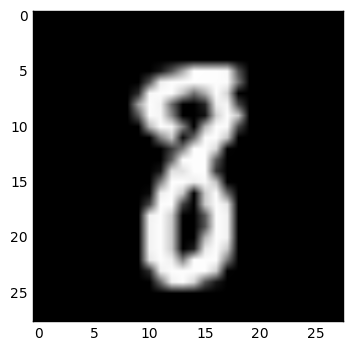

In [23]:
img = mnist.train.images[50]
plt.imshow(img.reshape((28,28)),cmap = 'Greys_r')

### 构建模型
#inputs
#generator
#descriminator
#loss&&optimizer

Inputs

In [24]:
def get_inputs(real_size, noise_size):
    """
    真实图像tensor与噪声图像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

Generator

In [25]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    n_units: 隐层单元个数
    out_dim: 生成器输出tensor的size，这里应该为32*32=784
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

Discriminator

In [26]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

#### 定义参数 

In [27]:
# 定义参数
# 真实图像的size
img_size = mnist.train.images[0].shape[0]
# 传入给generator的噪声size
noise_size = 100
# 生成器隐层参数
g_units = 128
# 判别器隐层参数
d_units = 128
# leaky ReLU的参数
alpha = 0.01
# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1

#### 构建网格 

In [28]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

In [29]:
#discriminator的loss
#识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real))*(1-smooth))

#识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))

#总体loss
d_loss = tf.add(d_loss_real,d_loss_fake)

#generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake))*(1-smooth))

Optimizer
#由于在GAN里面一共训练了两个网络，所以需要分别定义优化函数

In [30]:
train_vars = tf.trainable_variables()

#generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith('generator')]

#discriminator 中的tensor
d_vars = [var for var in train_vars if var.name.startswith('discriminator')]

#optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss,var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss,var_list=g_vars)

#### 训练

In [31]:
 #batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')

# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... Discriminator Loss: 0.0277(Real: 0.0023 + Fake: 0.0253)... Generator Loss: 3.7332
Epoch 2/300... Discriminator Loss: 0.2289(Real: 0.0893 + Fake: 0.1396)... Generator Loss: 3.1214
Epoch 3/300... Discriminator Loss: 1.9690(Real: 1.0530 + Fake: 0.9160)... Generator Loss: 3.3372
Epoch 4/300... Discriminator Loss: 0.6803(Real: 0.5296 + Fake: 0.1506)... Generator Loss: 2.9626
Epoch 5/300... Discriminator Loss: 0.8794(Real: 0.5480 + Fake: 0.3314)... Generator Loss: 2.5037
Epoch 6/300... Discriminator Loss: 1.1705(Real: 0.3669 + Fake: 0.8036)... Generator Loss: 2.1488
Epoch 7/300... Discriminator Loss: 1.7331(Real: 1.1540 + Fake: 0.5791)... Generator Loss: 1.2961
Epoch 8/300... Discriminator Loss: 0.7511(Real: 0.3587 + Fake: 0.3923)... Generator Loss: 1.6287
Epoch 9/300... Discriminator Loss: 1.1705(Real: 0.8943 + Fake: 0.2762)... Generator Loss: 2.5686
Epoch 10/300... Discriminator Loss: 2.0437(Real: 1.2336 + Fake: 0.8101)... Generator Loss: 1.3376
Epoch 11/300... Discriminator

#### 绘制loss曲线 

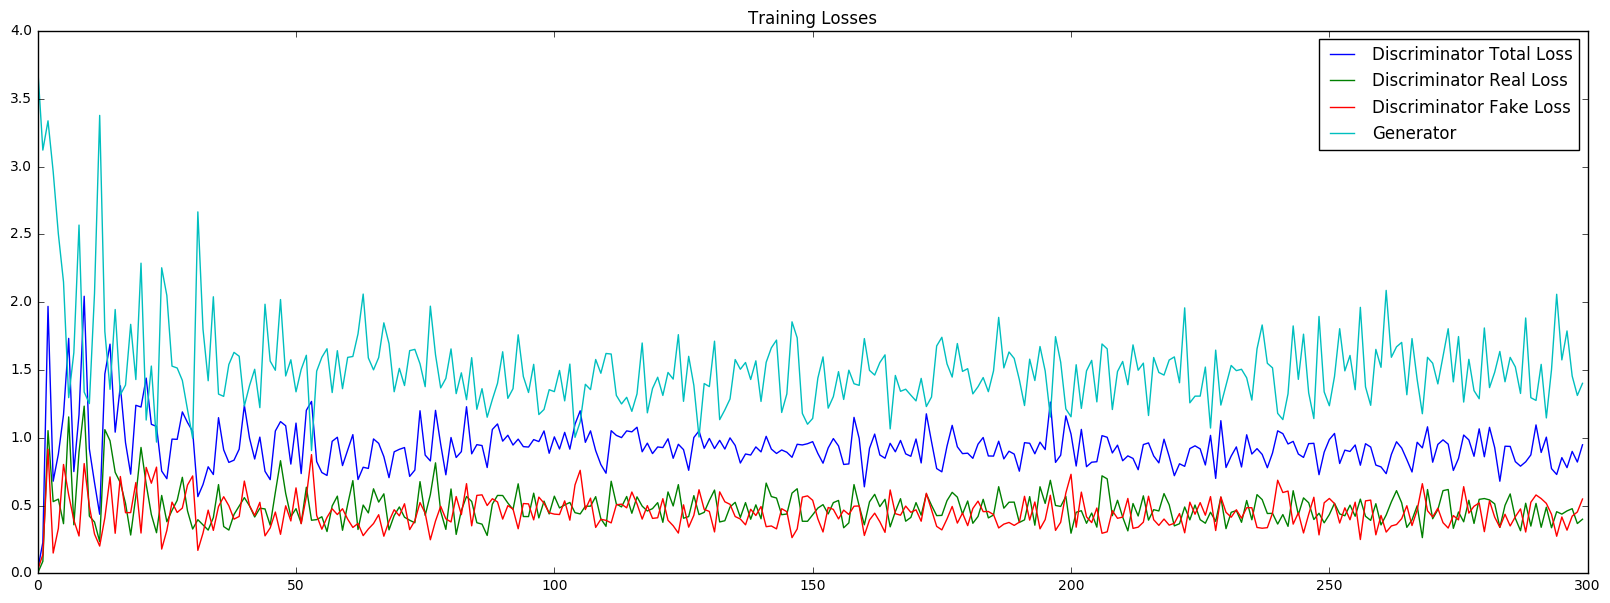

In [32]:
fig,ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0],label='Discriminator Total Loss')
plt.plot(losses.T[1],label='Discriminator Real Loss')
plt.plot(losses.T[2],label='Discriminator Fake Loss')
plt.plot(losses.T[3],label='Generator')
plt.title("Training Losses")
plt.legend()

#### 显示图像

In [34]:
#load samples from generator taken while training
with open('train_samples.pkl','rb') as f:
    samples = pickle.load(f)

In [35]:
def view_samples(epoch,samples):
    """
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    """
    fig,axes = plt.subplots(figsize=(7,7),nrows=5,ncols=5,sharey=True,sharex=True)
    for ax,img in zip(axes.flatten(),samples[epoch][1]):
        #这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)),cmap='Greys_r')
    return fig,axes


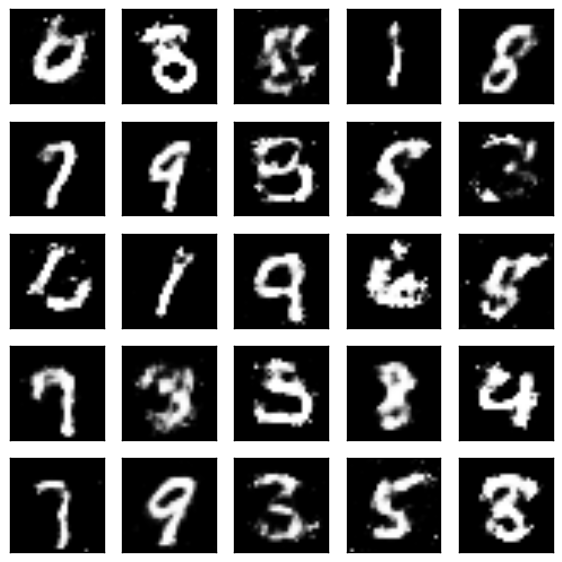

In [36]:
_ = view_samples(-1,samples)#最后一轮的outputs

#### 显示整个生成图像的过程

In [37]:
#指定要查看的轮次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 250]#一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

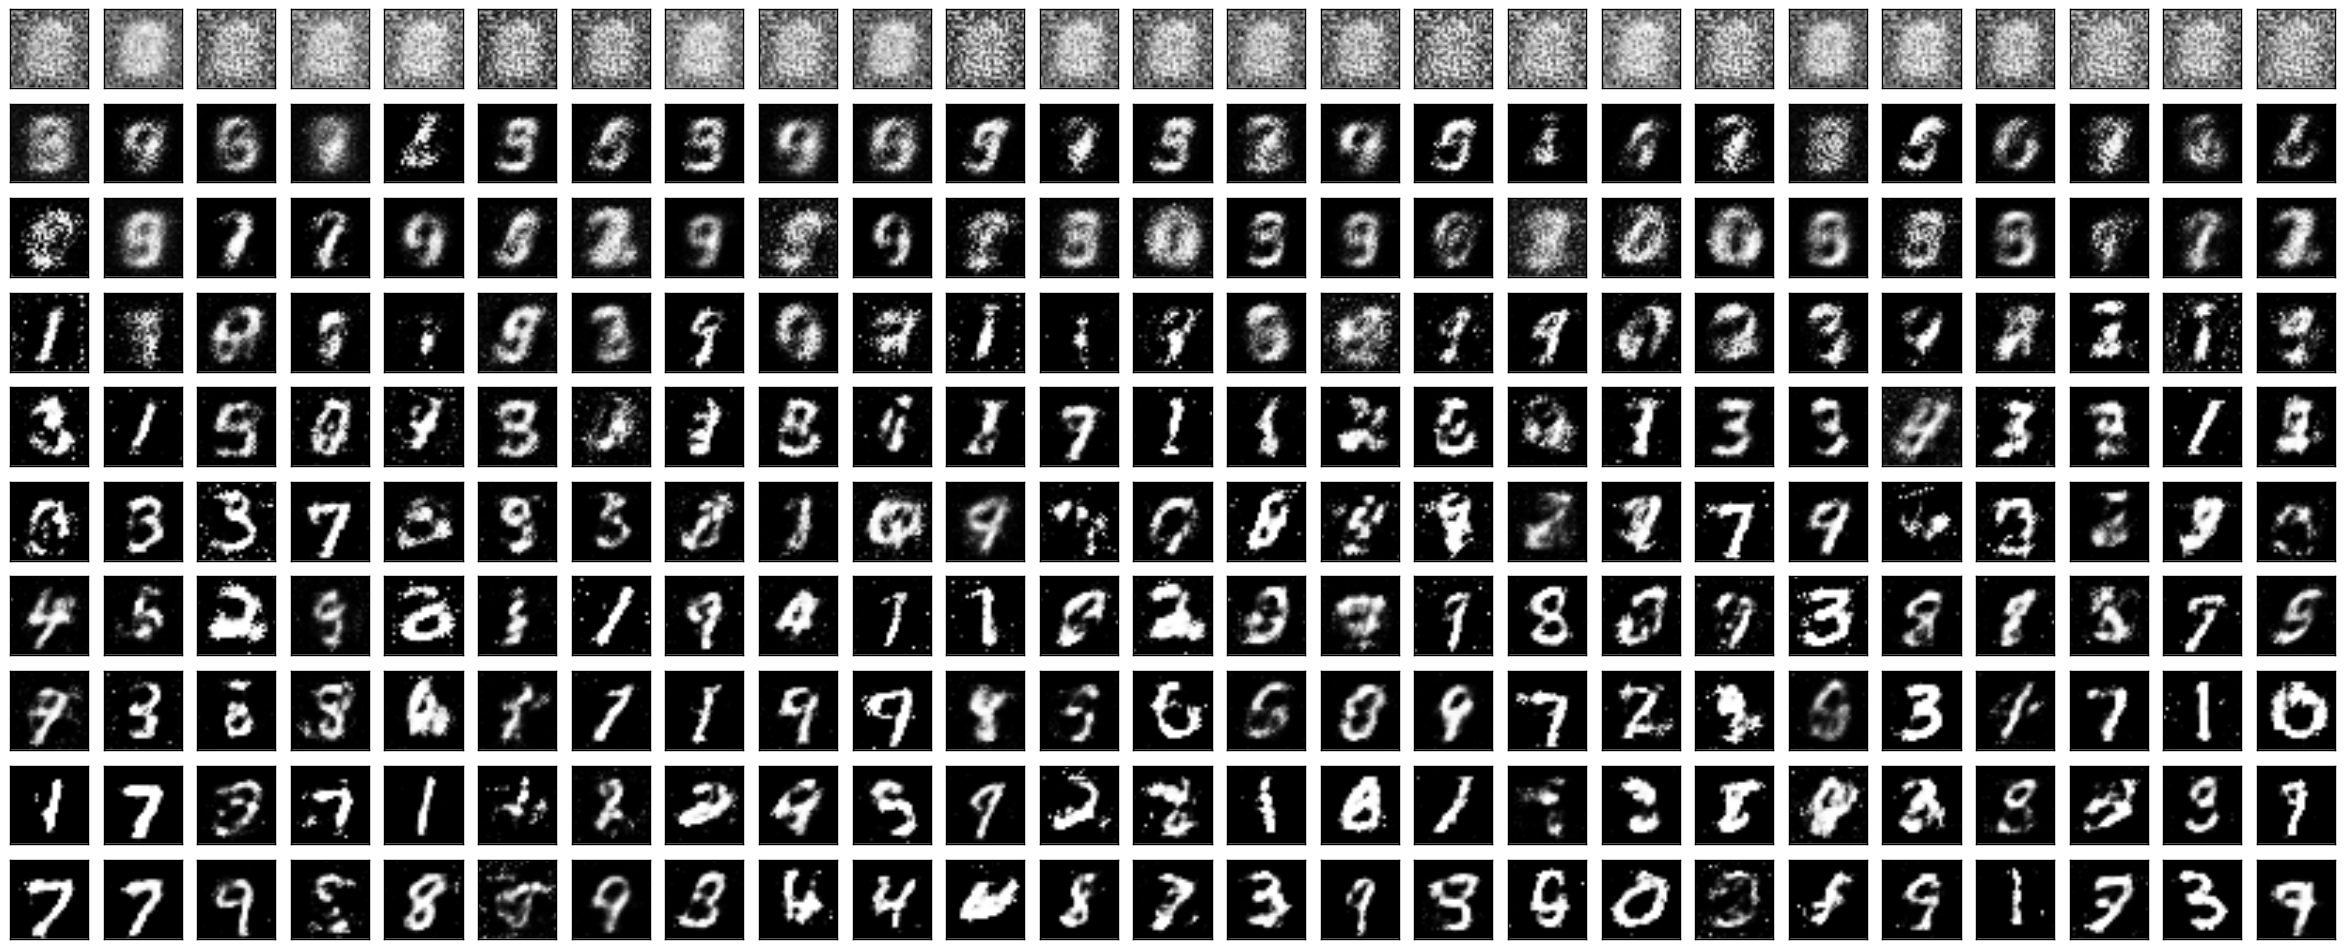

In [38]:
#指定图片形状
rows, cols = 10,25
fig, axes = plt.subplots(figsize=(30,12),nrows=rows,ncols=cols,sharex=True,sharey=True)

idx = range(0,epochs,int(epochs/rows))

for sample,ax_row in zip(show_imgs,axes):
    for img,ax in zip(sample[::int(len(sample)/cols)],ax_row):
        ax.imshow(img.reshape((28,28)),cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

#### 生成新的图片 

In [40]:
#加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1,1,size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img,g_units,img_size,reuse=True),feed_dict={noise_img:sample_noise})
    

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


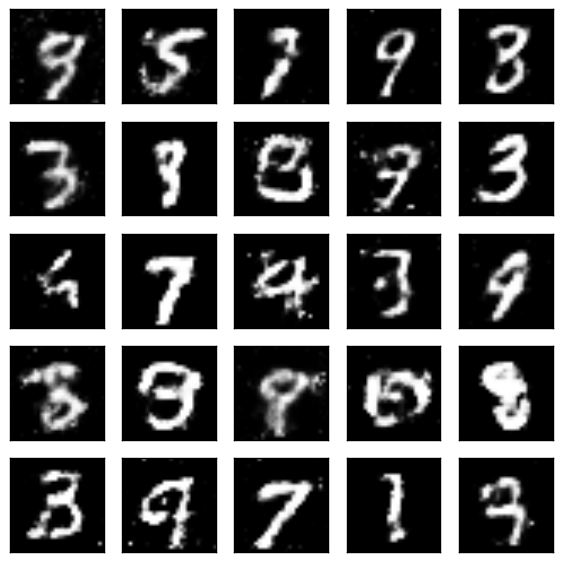

In [41]:
 _ = view_samples(0, [gen_samples])